<a href="https://colab.research.google.com/github/Vanessa-Taing/Projects_Playground/blob/main/GeneratingRealisticLookingHandwrittenDigitsWithGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import keras
import tensorflow as tf

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers.legacy import Adam
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)

In [ ]:
def build_generator():
  noise_shape = (100,)

  model = Sequential()
  model.add(Dense(256, input_shape = noise_shape))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Dense(1024))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))

  model.add(Dense(np.prod(img_shape),activation='tanh'))
  model.add(Reshape(img_shape))

  noise = Input(shape=noise_shape)
  img = model(noise)

  # optimizer.build(model.trainable_variables)

  return Model(noise, img)

In [ ]:
def build_discriminator():

  model = Sequential()

  model.add(Flatten(input_shape=img_shape))
  model.add(Dense(512))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dense(256))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()

  img = Input(shape=img_shape)
  validity = model(img)

  return Model(img, validity)

In [ ]:
def train(epochs, batch_size=128, save_interval=500):
  (X_train,_), (_,_) = mnist.load_data()
  X_train = (X_train.astype(np.float32) - 127.5) / 127.5

  X_train = np.expand_dims(X_train, axis=3)

  half_batch = int(batch_size/ 2)

  for epoch in range(epochs):

    idx = np.random.randint(0, X_train.shape[0], half_batch)
    imgs = X_train[idx]

    noise = np.random.normal(0,1,(half_batch, 100))

    gen_imgs = generator.predict(noise)

    d_loss_real = discriminator.train_on_batch(imgs,np.ones((half_batch,1)))
    d_loss_fake = discriminator.train_on_batch(gen_imgs,np.zeros((half_batch, 1)))

    d_loss = 0.5*np.add(d_loss_real, d_loss_fake)

    # Train generator
    noise = np.random.normal(0, 1, (batch_size, 100))
    valid_y = np.array([1] * batch_size)
    g_loss = combined.train_on_batch(noise, valid_y)

    print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
    if epoch % save_interval == 0:
            save_imgs(epoch)

In [ ]:
!mkdir images

mkdir: cannot create directory ‘images’: File exists


In [ ]:
def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("images/mnist_%d.png" % epoch)
    plt.close()

In [ ]:
optimizer = Adam(0.0002, 0.5)

discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])

generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

z = Input(shape=(100,))   #Our random input to the generator
img = generator(z)

discriminator.trainable = False

valid = discriminator(img)

combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

# optimizer.build(combined.trainable_variables)

train(epochs=1000, batch_size=32, save_interval=10)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 512)               401920    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 1)                 257       
                                                                 
Total params: 533505 (2.04 MB)
Trainable params: 53350

In [ ]:
generator.save('generator_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 109ms/step


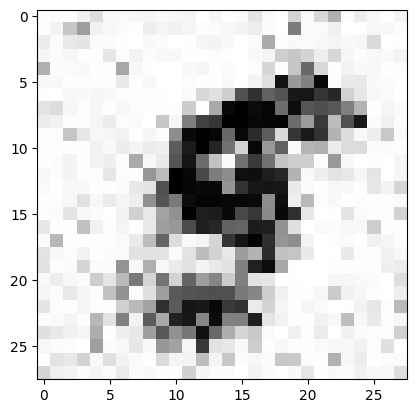

1/1 [==============================] - 0s 103ms/step


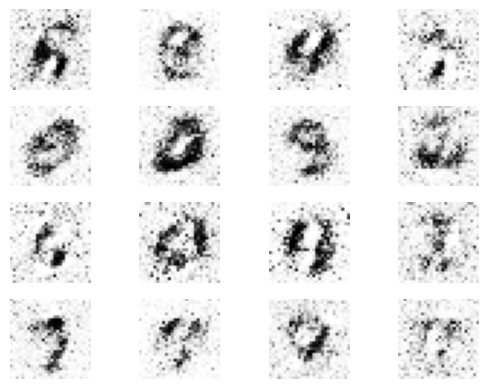

In [ ]:
#!/usr/bin/env python
__author__ = "Sreenivas Bhattiprolu"
__license__ = "Feel free to copy, I appreciate if you acknowledge Python for Microscopists"


# https://youtu.be/xBX2VlDgd4I   #Introduction video
# https://youtu.be/Mng57Tj18pc   #Keras implementation video.

"""
References from the video:
https://www.thispersondoesnotexist.com/
http://www.wisdom.weizmann.ac.il/~vision/courses/2018_2/Advanced_Topics_in_Computer_Vision/files/DomainTransfer.pdf
"""

#FOr single image
# example of generating an image for a specific point in the latent space
from keras.models import load_model
from numpy import asarray
from matplotlib import pyplot
from numpy.random import randn

# load model
model = load_model('generator_model.h5')

#To create same image, suppy same vector each time
# all 0s
#vector = asarray([[0. for _ in range(100)]])  #Vector of all zeros

#To create random images each time...
vector = randn(100) #Vector of random numbers (creates a column, need to reshape)
vector = vector.reshape(1, 100)

# generate image
X = model.predict(vector)

# plot the result
pyplot.imshow(X[0, :, :, 0], cmap='gray_r')
pyplot.show()


#Uncomment to run this part of the code....
##############################################

# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot as plt


# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i, :, :, 0], cmap='gray_r')
	plt.show()

# load model
model = load_model('generator_model.h5')
# generate images
#Generate 16 images, each image provide a vector of size 100 as input
latent_points = generate_latent_points(100, 16)
# generate images
X = model.predict(latent_points)
# plot the result
save_plot(X, 4)  #Plot 4x4 grid (Change to 5 if generating 25 images)

